In [1]:
import numpy as np
from numpy.testing import assert_allclose

import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import edrixs
from solvers import ed_1v1c_py, rixs_1v1c_py
from manybody_operator_csr import two_fermion_csr, four_fermion_csr
#, get_A

from scipy.sparse.linalg import aslinearoperator
from lanczos import lanczos_tridiagonal

#%matplotlib inline

# Run a calcuation using the regular python solver
The regular function `ed_1v1c_py` is modified to return various useful information

## required info
$H$ is `hmat` --- sparse initial state Hamiltonian

$\widetilde{H}$ is `hmat_int` --- sparse intermediate state Hamiltonian


## values for dense calculation and checks
$E_i$ is `eval_i_all` --- all initial state eignevalues

$\ket{i}$ is `evec_i_all` --- all initial state eignevectors

$E_n$ is `eval_n_all` --- all intermediate state eignevalues

$\ket{n}$ is `evec_n_all` --- all intermediate state eignevectors

In [2]:
shell_name = ('d', 'p')
v_noccu=8
slater = ([0.0, 12.234, 7.598],
          [0.0, 12.234, 7.598, 0.0, 7.721, 5.787, 3.291])

c_soc = 11.507
v_soc=(0.05, 0.09)

shell_level = (0, -886.5)
info_shell = edrixs.info_atomic_shell()

v_cfmat = edrixs.cf_cubic_d(1.07)

eval_i_all, evec_i_all, eval_n_all, evec_n_all, trans_op, basis_i, basis_n, hmat, hmat_int, ntot = ed_1v1c_py(shell_name, shell_level=shell_level, c_soc=c_soc,
                                      v_noccu=v_noccu, v_cfmat = v_cfmat, v_soc = v_soc, slater=slater,csr=True)

temperature = 300  # in K

ominc = [853]
eloss = np.arange(-1, 5, 0.01)

gamma_c = 0.5
gamma_f = 0.05
thin = np.deg2rad(30)
thout = np.deg2rad(30)
phi = 0
pol_type = [('linear', 0, 'linear', 0)] #, ('linear', 0, 'linear', np.pi/2)]
assert len(pol_type) == 1, "Code implemented for 1 polarization at the moment"

gs_list = [0, 1, 2]

rixs_map = rixs_1v1c_py(eval_i_all, eval_n_all, trans_op, ominc, eloss,
                 gamma_c=gamma_c, gamma_f=gamma_f, thin=thin, thout=thout, phi=phi,
                 pol_type=pol_type, gs_list=gs_list,temperature=temperature)
rixs = rixs_map.sum((-3, -1))

# Start Krylov implementation

Obtain a handful of the eigenvectors of the ground state Hamiltonian 
$$
{\cal H} \ket{i} = E_i \ket{i}
$$

Krylov subspace methods hate exact degeneracies in the ground state. Block methods, e.g. LOBPCG tend to be more robust, but occasionally fail to converge

In [4]:
X0 = np.random.rand(hmat.shape[0], 3)
eval_i, evec_i = scipy.sparse.linalg.lobpcg(hmat, X0, largest=False, tol=1e-9, maxiter=200 )

np.testing.assert_allclose(eval_i_all[:len(gs_list)], eval_i[:len(gs_list)], rtol=1e-10, atol=1e-12)

Generate the absorption and emission operators `Di_ylm` and `Df_ylm` in single particle $Y^l_m$ basis

In [5]:
Top_ylm = edrixs.get_trans_oper(shell_name[0] + shell_name[1])

ei, ef = edrixs.dipole_polvec_rixs(thin, thout, phi, pol_type[0][1], pol_type[0][3])
Di_ylm = sum(T*i for T, i in zip(Top_ylm, ei))
Df_ylm = sum(T*i for T, i in zip(Top_ylm, ef))

Create the absoprtion operator ${\cal D}_{\boldsymbol{k},\hat{\epsilon}}$ in the fock basis `Di` and equivalent emission operator ${\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}$ called `Df`.

In [6]:
v_norb = info_shell[shell_name[0]][1]
c_norb = info_shell[shell_name[1]][1]

tmp = np.zeros((ntot, ntot), dtype=complex)

tmp[0:v_norb, v_norb:ntot] = Di_ylm
Di = two_fermion_csr(tmp, basis_n, basis_i)

tmp[0:v_norb, v_norb:ntot] = Df_ylm
Df = two_fermion_csr(tmp, basis_n, basis_i)

Compute
$$
\ket{b_i} = {\cal D}_{\boldsymbol{k},\hat{\epsilon}} \ket{i}.
$$

Solve the following linear equation, involving the intermediate state Hamiltontian ${\cal \widetilde{H}}$ via sparse [MINRES](https://en.wikipedia.org/wiki/Minimal_residual_method) methods

$$
\hat{A} \ket{x_i} = \ket{b_i}
$$

where
$$
\hat{A} = \left({\cal \widetilde{H}} - E_i - \hbar\omega_{\boldsymbol{k}}+i\Gamma_c\right)
$$

Iterative methods typically need only a function that returns $\hat{A} \ket{x_i}$, coded as `get_A` instead of storing the full matrix. Since this matrix is not hermitian (explicit I factors in diagonal), we use GMRES.

In [8]:
bvec = np.array([Di @ evec_i[:,i] for i in np.arange(len(gs_list))])

xvec = np.zeros([len(gs_list), len(bvec[0])], dtype=complex)
for q in range(len(ominc)):        
    for l in range(len(bvec)):
        get_A = lambda x: -hmat_int @ x + (ominc[q] + eval_i[l] + 1j*gamma_c) * x
        A = sp.linalg.LinearOperator(shape=hmat_int.shape, matvec=get_A, dtype=hmat_int.dtype)
        xvec[l], info_mr = sp.linalg.gmres(A, bvec[l], tol=1e-9, maxiter=50000, restart=200)

Apply emission operator

$$
\ket{F_i} = {\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}  \ket{x_i}
$$

In [9]:
Fvec = np.zeros([len(gs_list), len(evec_i)], dtype=complex)
for l in range(len(xvec)):
    Fvec[l] = Df.getH() @ xvec[l]

* The spectrum can then be represented as

$$
I \propto -\sum_{i}e^{- E_{i}/(k_\mathrm{B}T)} \Im \bra{F_i} \frac{1}{{\cal H} - E_i - \hbar\omega_{\boldsymbol{q}}+i \Gamma} \ket{F_i}
$$

The continued fraction technique is then used to construct the spectrum. The ground state Hamiltonian $H$ (`hmat`) is represented in terms of an $m$ order Krylov subspace based on seed vector $\ket{F_i}$ (`Fvec`). The matrix operation then involves a much smaller tridiagonal matrix, $m\times m$ in size, which can be solved effciently with the `scipy.linalg.solve_banded` method.

In [11]:
poles_dict = {
    'npoles': [],
    'eigval': [],
    'norm': [],
    'alpha': [],
    'beta': []
}
for idx_j, j in enumerate(gs_list):
    phi_j = Fvec[idx_j]          # |Phi_j>
    E_j   = eval_i[j]            # its energy

    alpha_j, beta_j, norm_j = lanczos_tridiagonal(hmat, Fvec[j], m=200)

    poles_dict['npoles'].append(len(alpha_j))
    poles_dict['eigval'].append(E_j)
    poles_dict['norm'].append(norm_j)
    poles_dict['alpha'].append(alpha_j)
    poles_dict['beta'].append(beta_j)

In [18]:
prob = edrixs.boltz_dist(eval_i, temperature)
rixs_Krylov = [prob[j]*edrixs.get_spectra_from_poles(poles_dict, eloss, gamma_f, temperature)  for j in range(len(eval_i))]
rixs_Krylov=np.array(rixs_Krylov).sum(axis=0)

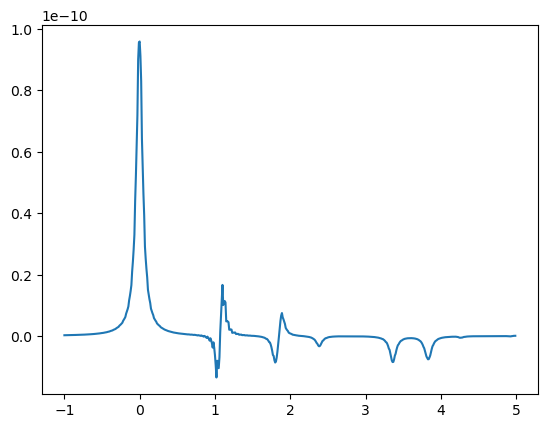

In [19]:
plt.plot(eloss,rixs-rixs_Krylov)

Text(0, 0.5, 'I')

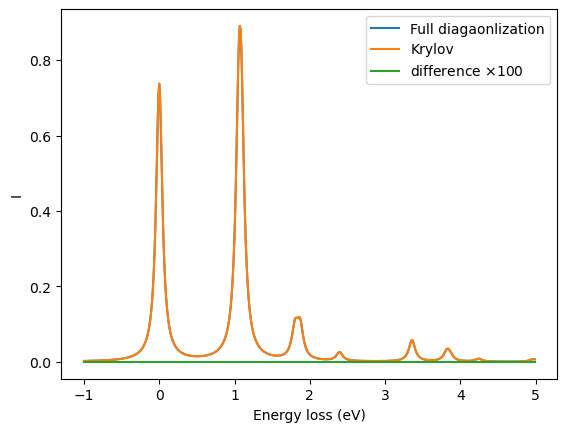

In [20]:
fig, ax = plt.subplots()

ax.plot(eloss, rixs, label='Full diagaonlization')
ax.plot(eloss, rixs_Krylov, label='Krylov')
ax.plot(eloss, 100*(rixs - rixs_Krylov), label=r'difference $\times100$')

ax.legend()
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')